In [2]:
import argparse
import concurrent.futures
import json
import os
import subprocess
import sys
from collections import defaultdict
from pathlib import Path
from typing import Any, Callable, Dict, List, Optional

import dash_core_components as dcc
import dash_html_components as html
import gin
import lib_analysis
import lib_biased_mnist
import lib_plot
import lib_problem
import lib_toy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
import yaml
from jupyter_dash import JupyterDash
from PIL import Image
from tqdm import tqdm

external_stylesheets = ["https://codepen.io/chriddyp/pen/bWLwgP.css"]

tqdm.pandas()
gin.enter_interactive_mode()

In [3]:
def read_df(data_root: Path, experiment_name: str) -> pd.DataFrame:
    df_path = data_root / experiment_name / "df.pickle"
    if df_path.exists():
        print(f"Found cached df at {df_path}. Reusing...", flush=True)
        return pd.read_pickle(str(df_path))

    DF = lib_analysis.read_problem(data_root, experiment_name)
    DF = lib_analysis.add_statistics_to_df(DF)

    DF.to_pickle(str(df_path), protocol=4)
    return DF

In [4]:
data_root = Path("../data/")
DF = read_df(data_root, "biased_mnist_10_digits")

Found cached df at ../data/biased_mnist_10_digits/df.pickle. Reusing...


In [9]:
gin.parse_config_file("/home/ericpts/work/data/biased_mnist_10_digits/conditional_hsic/mlp/label_correlation_0.997/rbf_kernel/lambda_64/noise_0/initial_lr0.01/run_2/config.gin")

tf.keras.backend.clear_session()

problem = lib_biased_mnist.BiasedMnistProblem()
in_dist = problem.generate_id_testing_data(include_bias=True)
oo_dist = problem.generate_ood_testing_data(include_bias=True)

In [22]:
def process_df(df: pd.DataFrame, batch_size: int):
    models = []

    for p in df["model_paths"].iloc[0]:
        p = str(p).replace("biased_mnist", "biased_mnist_10_digits")
        m = tf.keras.models.load_model(p, compile=False)
        models.append(m)

    in_X, in_y, in_y_biased, in_y_hat, in_d_loss = lib_analysis.process_dataset(
        in_dist, models, batch_size, True, "cka"
    )
    oo_X, oo_y, oo_y_biased, oo_y_hat, oo_d_loss = lib_analysis.process_dataset(
        oo_dist, models, batch_size, True, "cka"
    )

    dfs = [
        {"diversity": np.asarray(in_d_loss), "source": "id"},
        {"diversity": np.asarray(oo_d_loss), "source": "ood"},
    ]
    df = pd.concat(map(pd.DataFrame, dfs))
    return df

In [25]:
DF = DF[DF["indep"] == "cka"]
df_one = DF[
    (DF["Problem.initial_lr"] == 0.001)
    & (DF["label_correlation"] == 0.99)
    & (DF["lambda"] == 4)
].sample()
df_one

,test_prediction_loss,test_accuracy,test_diversity_loss,test_combined_loss,test_ensemble_accuracy,train_prediction_loss,train_accuracy,train_diversity_loss,train_combined_loss,train_ensemble_accuracy,...,BiasedMnistProblem.background_noise_level,Problem.n_epochs,Problem.initial_lr,Problem.decrease_lr_at_epochs,Problem.n_models,get_weight_regularizer.strength,yaml_config_file,gin_config_file,ood_statistics,id_statistics
1550,"[7.6209588050842285, 4.207597732543945]","[0.2013999968767166, 0.382999986410141]",0.24683,12.815878,0.3019,"[0.11607113480567932, 0.062184520065784454]","[0.9896166920661926, 0.9911500215530396]",0.155275,0.799356,0.99185,...,0,100,0.001,"[20, 40, 80]",2,0.01,/home/ericpts/work/data/biased_mnist/cka/mlp/l...,/home/ericpts/work/data/biased_mnist/cka/mlp/l...,{'overall': {'ensemble': {'accuracy': tf.Tenso...,{'overall': {'ensemble': {'accuracy': tf.Tenso...


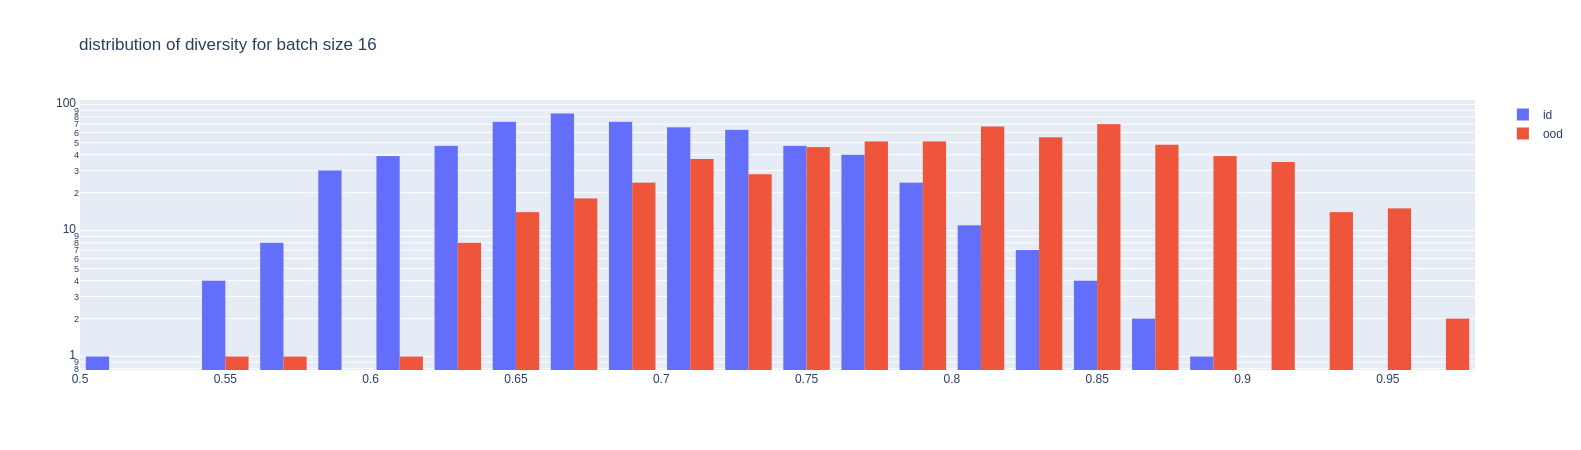

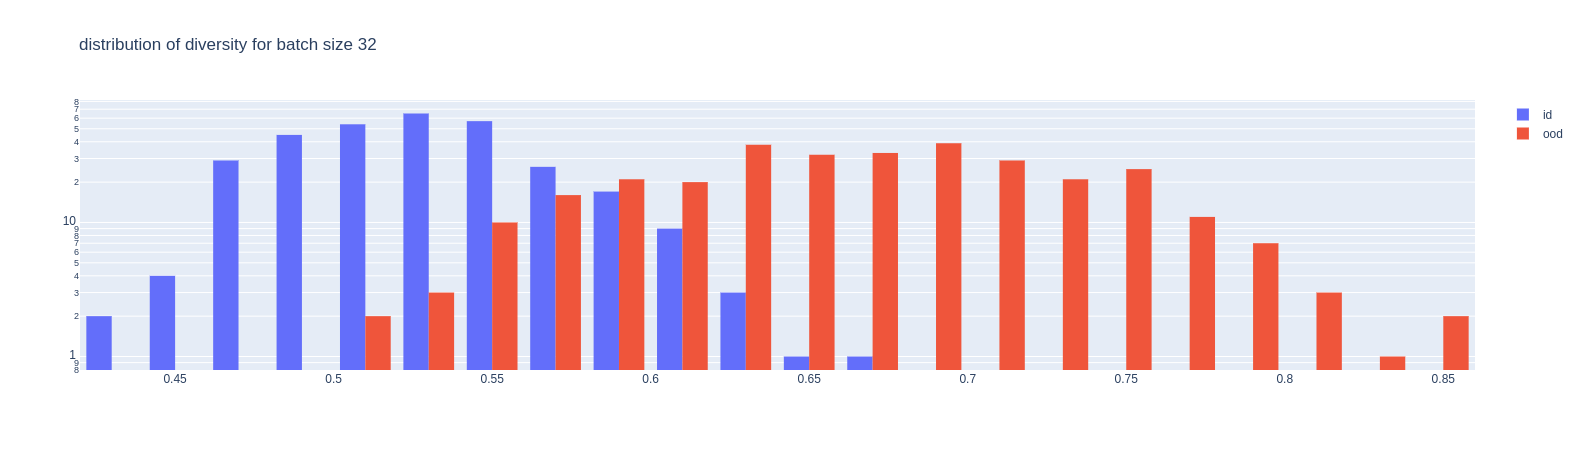

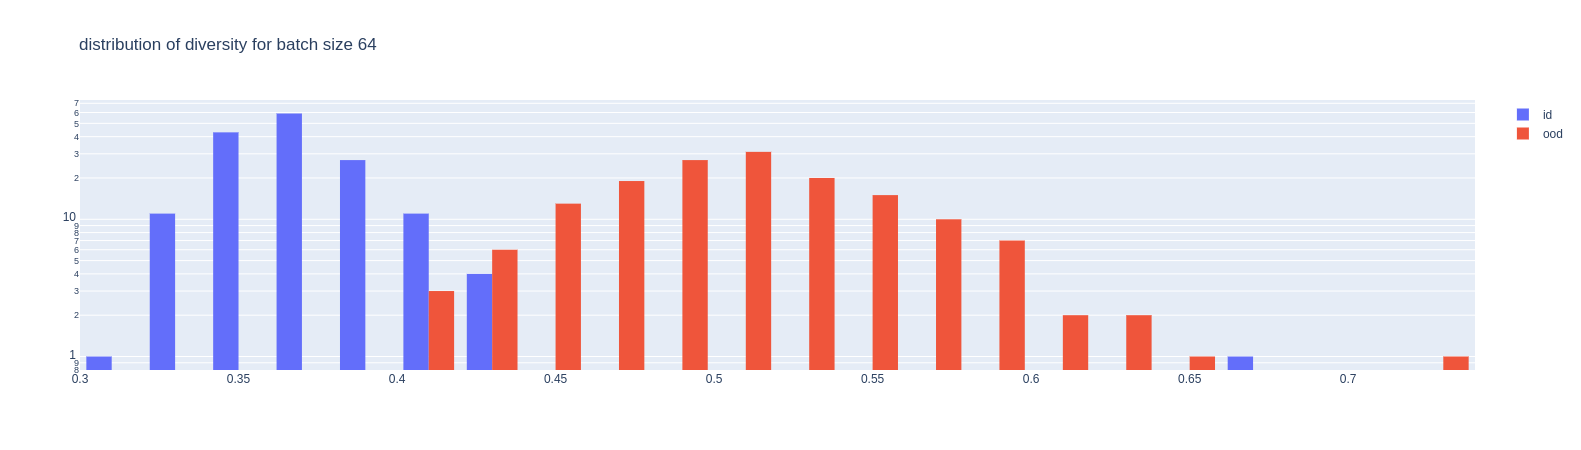

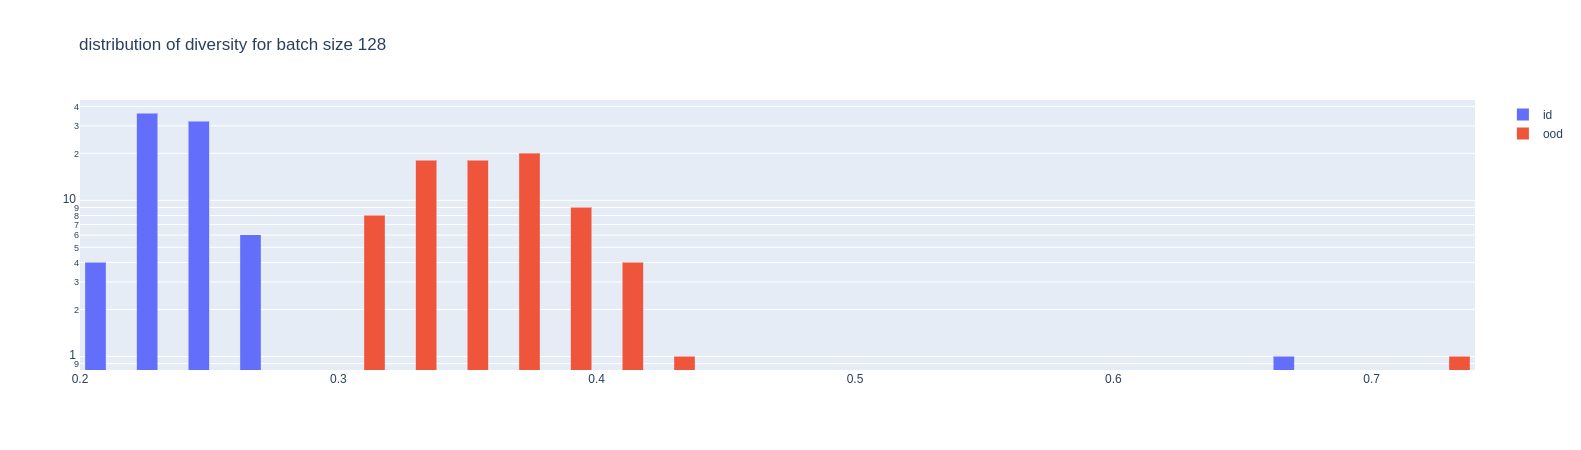

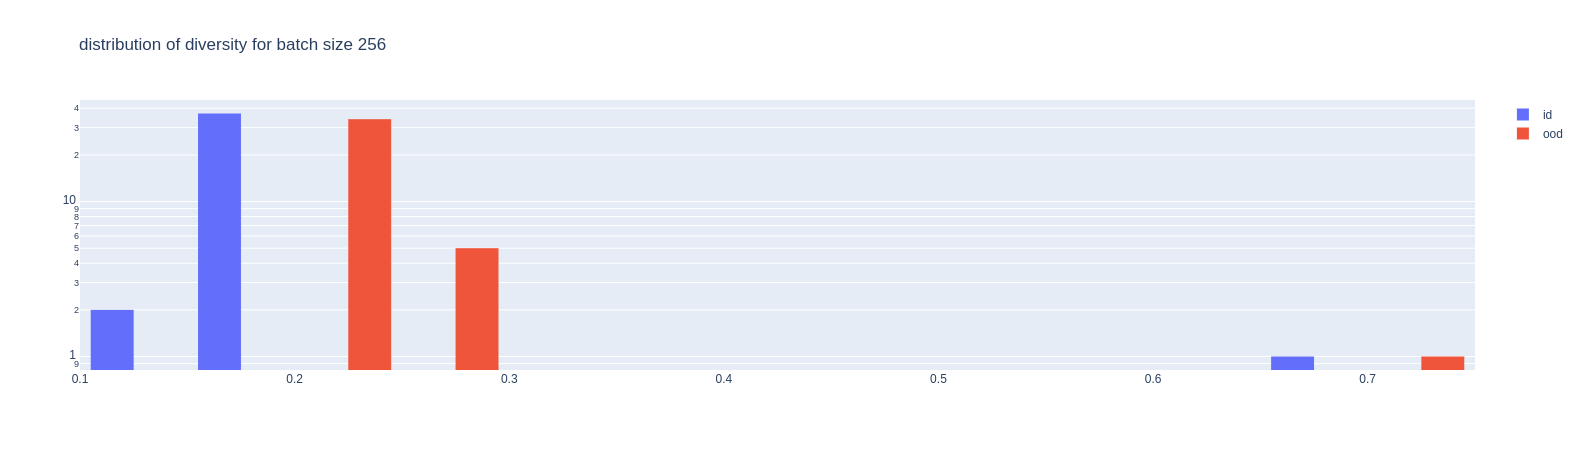

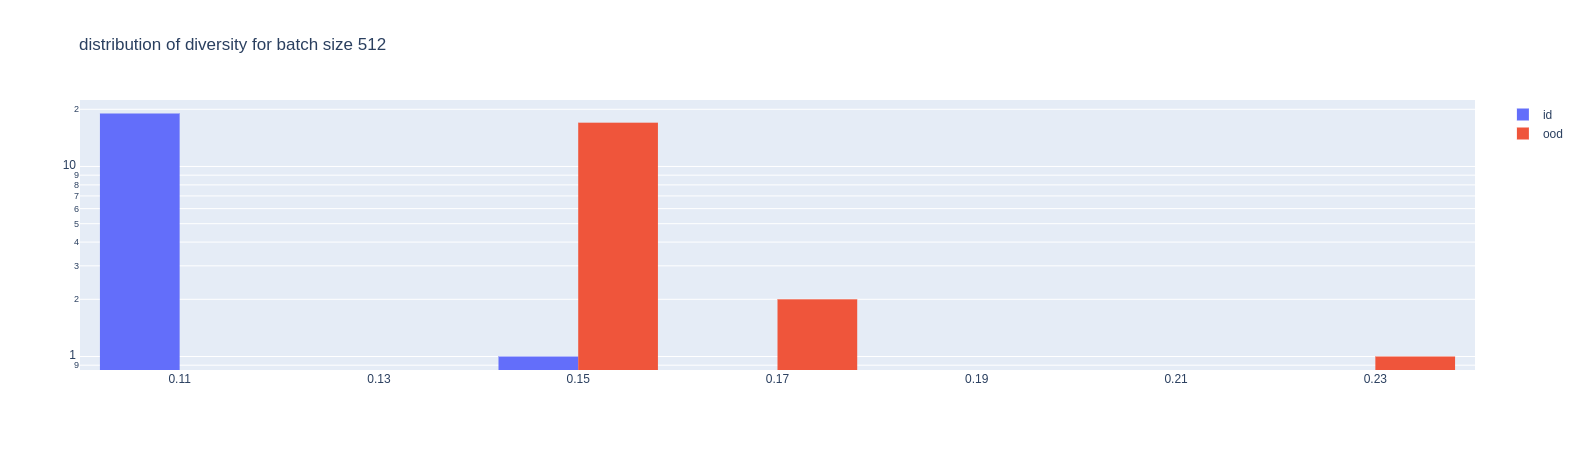

In [26]:
def make_histogram(df: pd.DataFrame, batch_size: int):
    fig = go.Figure()
    for s in df.source.unique():
        sel_df = df[df["source"] == s]
        fig.add_trace(go.Histogram(x=sel_df.diversity.to_numpy(), name=s))
    fig.update_layout(
        title=f"distribution of diversity for batch size {batch_size}",
        yaxis_type="log",
    )
    fig.show()


for bs in [16, 32, 64, 128, 256, 512]:
    df = process_df(df_one, bs)
    make_histogram(df, bs)